In [153]:
import tushare as ts
print(f"tushare version:{ts.__version__}")
token = "8ef5ec61cdd848715c57c11d58dd71da1271f76b2420d2bac8aef123"
import os
#os.listdir()
import pandas as pd
futures_info = pd.read_excel("商品期货信息汇总.xlsx")
drop_ind = [1,2,3,10, 14, 15, 19, 20, 21, 22, 23]
left = futures_info.columns[drop_ind]
futures_info = futures_info.drop(columns = left)
print("Other features removed!")
import warnings
warnings.filterwarnings("ignore")
futures_info.head(2)

tushare version:1.2.54
Other features removed!


,交易所,品种,收盘价格,开盘价格,最低价,最高价,成交量,交易代码,主力代号（截至20190804）,保证金（%）（截至20190804）,手续费,交易单位（contractunit）/手OR每点价值/乘数,最小变动价位（元/吨）
0,上海期货交易所,沪金,278.55,NaN,NaN,NaN,NaN,AU,1906.0,7.0,10元/手,1000.0,0.05
1,大连商品交易所,焦炭,1972.00,NaN,NaN,NaN,NaN,J,1909.0,8.0,成交金额的万分之0.6,100.0,0.5


In [77]:
futures_info['保证金（%）（截至20190804）'].unique()

array([ 7.,  8.,  6.,  9., 12.,  5., 11., 10.,  4., nan])

In [32]:
futures_info.columns

Index(['交易所', '品种', '收盘价格', '开盘价格', '最低价', '最高价', '成交量', '交易代码',
       '主力代号（截至20190804）', '保证金（%）（截至20190804）', '手续费',
       '交易单位（contractunit）/手OR每点价值/乘数', '最小变动价位（元/吨）'],
      dtype='object')

In [2]:
print("查看Main Contract")
mc= futures_info[['交易所', '主力代号（截至20190804）']].drop_duplicates().dropna().sort_values('交易所')
mc['exchange'] = 'INE'

## 更改dataframe中满足条件行的特定行的值
SHFE = mc.loc[mc['交易所'] == "上海期货交易所"].index
DCE  = mc.loc[mc['交易所'] == "大连商品交易所"].index
CZCE = mc.loc[mc['交易所'] == "郑州商品交易所"].index
mc.loc[SHFE,'exchange'] = "SHFE"
mc.loc[DCE, 'exchange'] = 'DCE'
mc.loc[CZCE,'exchange'] = 'CZCE'


mc = mc.rename(columns = {'主力代号（截至20190804）':'MainContract'})
mc.MainContract = mc.MainContract.astype(str).str[:4]
mc = mc.iloc[:,1:].reset_index(drop = True)
mc_SHFE = mc.loc[mc.exchange == 'SHFE']
mc_SHFE

查看Main Contract


,MainContract,exchange
1,1906,SHFE
2,1912,SHFE
3,1910,SHFE
4,1905,SHFE
5,1909,SHFE
6,1907,SHFE


In [5]:
pro = ts.pro_api(token)

In [179]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 期货主要品种交易周报(FUT_WEEKLY_DAILY) 提取：
* 主力合约MainContract

In [98]:
all_columns = "exchange|prd|name|vol|vol_yoy|amount|amount_yoy|cumvol|cumvol_yoy|cumamt|cumamt_yoy|open_interest|interest_wow|mc_close|close_wow|week|week_date".split("|")
print("可选择输出：")
for c in range(len(all_columns)): print(f"{c}:{all_columns[c]}", end = " |")
futures_weekly_detail = pro.fut_weekly_detail(exchange = 'SHFE', start_week = "202001", end_week = "202003", fields = all_columns[:5])
futures_weekly_detail.tail()

可选择输出：
0:exchange |1:prd |2:name |3:vol |4:vol_yoy |5:amount |6:amount_yoy |7:cumvol |8:cumvol_yoy |9:cumamt |10:cumamt_yoy |11:open_interest |12:interest_wow |13:mc_close |14:close_wow |15:week |16:week_date |

,exchange,prd,name,vol,vol_yoy
43,SHFE,BU,沥青,1097328,0.8157
44,SHFE,RB,螺纹钢,4466780,-6.8969
45,SHFE,HC,热轧卷板,696632,-26.9996
46,SHFE,CU,铜,658216,-14.7655
47,SHFE,WR,线材,38,-99.2265


In [152]:
mc= futures_weekly_detail[['exchange', 'prd']].drop_duplicates()
mc.head()

,exchange,prd
0,SHFE,SS
1,SHFE,AU
2,SHFE,RB
3,SHFE,RU
4,SHFE,HC


## 根据期货合约信息表 (fut_basic) 提取:
* 品种/name， 交易代码/symbol， 交易所/exchange， 主力代号/MainContract

In [150]:
"""
期货合约信息表目前只能获取普通合约
"""
futures_contract= pro.fut_basic(exchange='SHFE', fut_type='1', fields='ts_code,symbol,name,list_date,delist_date')
print("\t|合约代码|交易标识|中文简称|上市日期|最后交易日期|")
futures_contract.head()

	|合约代码|交易标识|中文简称|上市日期|最后交易日期|


,ts_code,symbol,name,list_date,delist_date
0,AL1508.SHF,AL1508,沪铝1508,20140818,20150817
1,RU1508.SHF,RU1508,橡胶1508,20140818,20150817
2,RB1508.SHF,RB1508,螺纹钢1508,20140818,20150817
3,AG1508.SHF,AG1508,沪银1508,20140818,20150817
4,HC1508.SHF,HC1508,热轧卷板1508,20140818,20150817


In [151]:
futures_contract['prd'] = futures_contract.symbol.str[:-4]
futures_contract['MainContract'] = futures_contract.name.str[-4:]
futures_contract['name'] = futures_contract.name.str[:-4]
futures_contract.drop(columns = ["ts_code", "list_date", "delist_date"], inplace = True)
futures_contract.head()

,symbol,name,prd,MainContract
0,AL1508,沪铝,AL,1508
1,RU1508,橡胶,RU,1508
2,RB1508,螺纹钢,RB,1508
3,AG1508,沪银,AG,1508
4,HC1508,热轧卷板,HC,1508


In [109]:
futures_MainContract = futures_contract.merge(mc, on = ['prd'])
futures_MainContract.head()

,symbol,name,prd,MainContract,exchange
0,AL1508,沪铝,AL,1508,SHFE
1,AL9608,沪铝,AL,9608,SHFE
2,AL1510,沪铝,AL,1510,SHFE
3,AL1511,沪铝,AL,1511,SHFE
4,AL1512,沪铝,AL,1512,SHFE


In [149]:
symbols = list(futures_MainContract.symbol.unique())
symbols[:4]

['AL1508', 'AL9608', 'AL1510', 'AL1511']

## 期货日线行情(fut_daily)提取：
* Open, High, Low, Close

In [122]:
futures_daily = pro.fut_daily(ts_code = "CU1811.SHF", start_date = "20180101", end_date = "20191231")
daily_columns = "合约代码|交易日期|昨日收盘价|昨日结算价|开盘价|最高价|最低价|收盘价|结算价|收盘价-昨日结算价|结算价-昨日结算价|成交量|成交金额（万)|持仓量|持仓量变化".split("|")
for c in daily_columns: print("", c, end = "|")
futures_daily.head()

 合约代码| 交易日期| 昨日收盘价| 昨日结算价| 开盘价| 最高价| 最低价| 收盘价| 结算价| 收盘价-昨日结算价| 结算价-昨日结算价| 成交量| 成交金额（万)| 持仓量| 持仓量变化|

,ts_code,trade_date,pre_close,pre_settle,open,high,low,close,settle,change1,change2,vol,amount,oi,oi_chg
0,CU1811.SHF,20181115,48750.0,48840.0,48840.0,49350.0,48470.0,49300.0,49030.0,460.0,190.0,3800.0,93169.60,7210.0,-1640.0
1,CU1811.SHF,20181114,49030.0,48830.0,49070.0,49240.0,48720.0,48750.0,48840.0,-80.0,10.0,14500.0,354162.25,8850.0,-7260.0
2,CU1811.SHF,20181113,48900.0,49030.0,48910.0,49040.0,48700.0,49030.0,48830.0,0.0,-200.0,17270.0,421721.70,16110.0,-6830.0
3,CU1811.SHF,20181112,49270.0,49340.0,49130.0,49200.0,48860.0,48900.0,49030.0,-440.0,-310.0,27710.0,679447.85,22940.0,-7160.0
4,CU1811.SHF,20181109,49440.0,49500.0,49340.0,49530.0,49120.0,49270.0,49340.0,-230.0,-160.0,22530.0,555910.15,30100.0,-4700.0


* The amount can be simulated with OHLC and Vol for each day, and the error is low

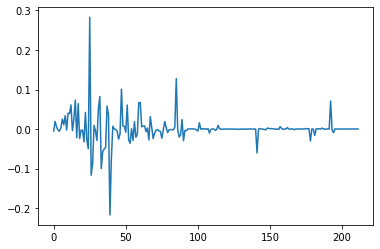

In [123]:
test = futures_daily.copy()
test['my_amnt'] = (0.5*(test.high+test.low)*test.vol/2000)
test['error'] = (test.my_amnt - test.amount)/(0.5*(test.high+test.low))

plt.plot(list(range(212)), test.error)

* 随机挑选20个合约代码

In [124]:
import random
ts_codes = [i + ".SHF" for i in symbols]## 创建主力合约列表
ts_codes = random.sample(ts_codes, 20)

* 提取主力合约的OHLC信息

In [169]:
futures_OHLC = pd.DataFrame(columns = futures_daily.columns)
failed_symbols = []
for ts_c in ts_codes:
    daily = pro.fut_daily(ts_code = ts_c, start_date = "20180101", end_date = "20191231")
    futures_OHLC = pd.concat([futures_OHLC, daily])
    if len(daily):
        print(f"Successfully get {ts_c} data! -- {len(daily)} rows", end = " / ")
        continue
    print("XXXX", end = " / ")
    failed_symbols.append(ts_c)
print(f"\n{len(failed_symbols)} symbols failed!")
futures_OHLC.reset_index(drop = True, inplace = True)
futures_OHLC.head()

XXXX / XXXX / XXXX / Successfully get SN1903.SHF data! -- 243 rows / Successfully get CU1912.SHF data! -- 242 rows / XXXX / XXXX / Successfully get SS2007.SHF data! -- 67 rows / XXXX / XXXX / Successfully get AG1810.SHF data! -- 189 rows / XXXX / XXXX / Successfully get HC1912.SHF data! -- 242 rows / XXXX / XXXX / XXXX / XXXX / XXXX / XXXX / 
15 symbols failed!


,ts_code,trade_date,pre_close,pre_settle,open,high,low,close,settle,change1,change2,vol,amount,oi,oi_chg
0,SN1903.SHF,20190315,150010.0,150010.0,NaN,NaN,NaN,150010.0,150010.0,0.0,0.0,0.0,0.0,0.0,0.0
1,SN1903.SHF,20190314,150010.0,150010.0,NaN,NaN,NaN,150010.0,150010.0,0.0,0.0,0.0,0.0,0.0,0.0
2,SN1903.SHF,20190313,150010.0,150010.0,NaN,NaN,NaN,150010.0,150010.0,0.0,0.0,0.0,0.0,0.0,0.0
3,SN1903.SHF,20190312,150010.0,150010.0,NaN,NaN,NaN,150010.0,150010.0,0.0,0.0,0.0,0.0,0.0,0.0
4,SN1903.SHF,20190311,150010.0,150010.0,NaN,NaN,NaN,150010.0,150010.0,0.0,0.0,0.0,0.0,0.0,0.0


In [171]:
OHLC = futures_OHLC.drop(columns = ['pre_close','pre_settle',"change1","change2","oi","oi_chg"])
OHLC['symbol'] = OHLC.ts_code.str[:-4]
OHLC = OHLC.drop(columns = ['ts_code'])
OHLC.amount *= 10000
OHLC.head()

,trade_date,open,high,low,close,settle,vol,amount,symbol
0,20190315,NaN,NaN,NaN,150010.0,150010.0,0.0,0.0,SN1903
1,20190314,NaN,NaN,NaN,150010.0,150010.0,0.0,0.0,SN1903
2,20190313,NaN,NaN,NaN,150010.0,150010.0,0.0,0.0,SN1903
3,20190312,NaN,NaN,NaN,150010.0,150010.0,0.0,0.0,SN1903
4,20190311,NaN,NaN,NaN,150010.0,150010.0,0.0,0.0,SN1903


* 很多交易量为0

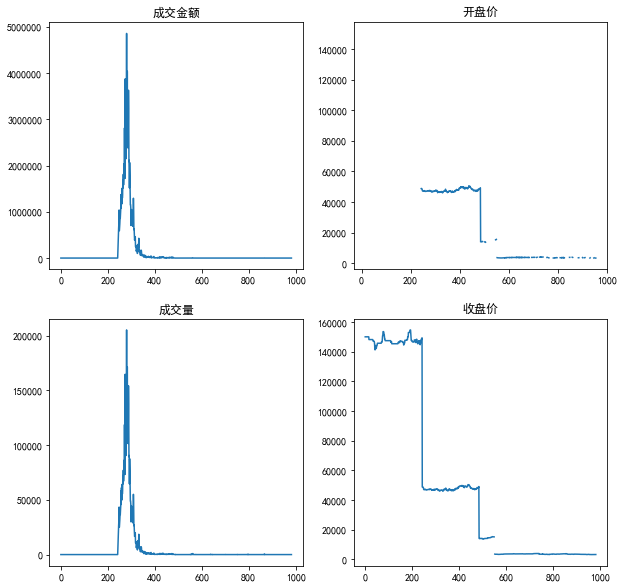

In [180]:
data_ind = list(range(len(futures_OHLC)))
fig, ax = plt.subplots(2,2, figsize = (10,10))
ax[0,0].plot(data_ind, futures_OHLC.amount)
ax[0,0].set_title("成交金额")

ax[0,1].plot(data_ind, futures_OHLC.open)
ax[0,1].set_title("开盘价")

ax[1,0].plot(data_ind, futures_OHLC.vol)
ax[1,0].set_title("成交量")

ax[1,1].plot(data_ind, futures_OHLC.close)
ax[1,1].set_title("收盘价")
plt.show()

## 结算参数(fut_settle)提取：
* 手续费/trading_fee, 保证金/margin_rate

In [136]:
futures_settle = pro.fut_settle(start_date = "20180101",end_date = "20191231", exchange = "SHFE")
settle_columns = "合约代码|交易日期|结算价|交易手续费率|交易手续费|交割手续费率|买套保交易保证金率|卖套保交易保证金率|买投机保证金率|卖投机保证金率"
settle_columns = settle_columns.split("|")
for c in settle_columns: print("",c, end = " |") 
futures_settle.tail()

 合约代码 | 交易日期 | 结算价 | 交易手续费率 | 交易手续费 | 交割手续费率 | 买套保交易保证金率 | 卖套保交易保证金率 | 买投机保证金率 | 卖投机保证金率 |

,ts_code,trade_date,settle,trading_fee_rate,trading_fee,delivery_fee,b_hedging_margin_rate,s_hedging_margin_rate,long_margin_rate,short_margin_rate
1595,PB2006.SHF,20191212,15115.0,0.04,0.0,2.0,0.07,0.07,0.07,0.07
1596,PB2005.SHF,20191212,15100.0,0.04,0.0,2.0,0.07,0.07,0.07,0.07
1597,PB2004.SHF,20191212,15120.0,0.04,0.0,2.0,0.07,0.07,0.07,0.07
1598,PB2003.SHF,20191212,15110.0,0.04,0.0,2.0,0.07,0.07,0.07,0.07
1599,PB2002.SHF,20191212,15125.0,0.04,0.0,2.0,0.07,0.07,0.07,0.07


In [144]:
"""
fut_settle rejects the parameter "ts_code", we have to search ALL the data and filter out the irreative ones
"""
all_settle = pro.fut_settle(start_date = "20180101",end_date = "20191231", exchange = "SHFE")
drop_ind = []
for index, row in all_settle.iterrows():
    if row.ts_code not in ts_codes:
        drop_ind.append(index)
futures_settle_mc = all_settle.drop(drop_ind) \
                              .reset_index(drop = True) \
                              .drop(columns = ['trading_fee_rate', 'delivery_fee'])
futures_settle_mc.head()

,ts_code,trade_date,settle,trading_fee,b_hedging_margin_rate,s_hedging_margin_rate,long_margin_rate,short_margin_rate
0,HC1912.SHF,20191216,3519.0,0.0,0.2,0.2,0.2,0.2
1,CU1912.SHF,20191216,48620.0,0.0,0.2,0.2,0.2,0.2
2,HC1912.SHF,20191213,3519.0,0.0,0.2,0.2,0.2,0.2
3,CU1912.SHF,20191213,48860.0,0.0,0.2,0.2,0.2,0.2
4,HC1912.SHF,20191212,3519.0,0.0,0.2,0.2,0.2,0.2


In [145]:
futures_settle_mc['margin_rate'] = 100*0.25*(futures_settle_mc.b_hedging_margin_rate 
                                         + futures_settle_mc.s_hedging_margin_rate 
                                         + futures_settle_mc.long_margin_rate 
                                         + futures_settle_mc.short_margin_rate)
futures_settle_mc['symbol'] = futures_settle_mc.ts_code.str[:-4]
futures_settle_mc = futures_settle_mc.drop(columns = ['ts_code','b_hedging_margin_rate', 's_hedging_margin_rate', 'long_margin_rate', 'short_margin_rate'])
futures_settle_mc.head()

,trade_date,settle,trading_fee,margin_rate,symbol
0,20191216,3519.0,0.0,20.0,HC1912
1,20191216,48620.0,0.0,20.0,CU1912
2,20191213,3519.0,0.0,20.0,HC1912
3,20191213,48860.0,0.0,20.0,CU1912
4,20191212,3519.0,0.0,20.0,HC1912


## Merge all relative data

In [181]:
futures_MainContract.head()

,symbol,name,prd,MainContract,exchange
0,AL1508,沪铝,AL,1508,SHFE
1,AL9608,沪铝,AL,9608,SHFE
2,AL1510,沪铝,AL,1510,SHFE
3,AL1511,沪铝,AL,1511,SHFE
4,AL1512,沪铝,AL,1512,SHFE


In [185]:
OHLC.head()

,trade_date,open,high,low,close,settle,vol,amount,symbol
0,20190315,NaN,NaN,NaN,150010.0,150010.0,0.0,0.0,SN1903
1,20190314,NaN,NaN,NaN,150010.0,150010.0,0.0,0.0,SN1903
2,20190313,NaN,NaN,NaN,150010.0,150010.0,0.0,0.0,SN1903
3,20190312,NaN,NaN,NaN,150010.0,150010.0,0.0,0.0,SN1903
4,20190311,NaN,NaN,NaN,150010.0,150010.0,0.0,0.0,SN1903


In [183]:
futures_settle_mc.head()

,trade_date,settle,trading_fee,margin_rate,symbol
0,20191216,3519.0,0.0,20.0,HC1912
1,20191216,48620.0,0.0,20.0,CU1912
2,20191213,3519.0,0.0,20.0,HC1912
3,20191213,48860.0,0.0,20.0,CU1912
4,20191212,3519.0,0.0,20.0,HC1912


In [186]:
SHFE = futures_MainContract.merge(OHLC, on = "symbol") \
                           .merge(futures_settle_mc, on = 'symbol')
print(f"Totally generate {len(SHFE)} rows of data!")
SHFE.head()

Totally generate 1210 rows of data!


,symbol,name,prd,MainContract,exchange,trade_date_x,open,high,low,close,settle_x,vol,amount,trade_date_y,settle_y,trading_fee,margin_rate
0,HC1912,热轧卷板,HC,1912,SHFE,20191216,NaN,NaN,NaN,3519.0,3519.0,0.0,0.0,20191216,3519.0,0.0,20.0
1,HC1912,热轧卷板,HC,1912,SHFE,20191216,NaN,NaN,NaN,3519.0,3519.0,0.0,0.0,20191213,3519.0,0.0,20.0
2,HC1912,热轧卷板,HC,1912,SHFE,20191216,NaN,NaN,NaN,3519.0,3519.0,0.0,0.0,20191212,3519.0,0.0,20.0
3,HC1912,热轧卷板,HC,1912,SHFE,20191213,NaN,NaN,NaN,3519.0,3519.0,0.0,0.0,20191216,3519.0,0.0,20.0
4,HC1912,热轧卷板,HC,1912,SHFE,20191213,NaN,NaN,NaN,3519.0,3519.0,0.0,0.0,20191213,3519.0,0.0,20.0


In [187]:
SHFE.dropna(inplace = True)
SHFE.head()

,symbol,name,prd,MainContract,exchange,trade_date_x,open,high,low,close,settle_x,vol,amount,trade_date_y,settle_y,trading_fee,margin_rate
33,HC1912,热轧卷板,HC,1912,SHFE,20191129,3565.0,3565.0,3500.0,3540.0,3519.0,134.0,4716000.0,20191216,3519.0,0.0,20.0
34,HC1912,热轧卷板,HC,1912,SHFE,20191129,3565.0,3565.0,3500.0,3540.0,3519.0,134.0,4716000.0,20191213,3519.0,0.0,20.0
35,HC1912,热轧卷板,HC,1912,SHFE,20191129,3565.0,3565.0,3500.0,3540.0,3519.0,134.0,4716000.0,20191212,3519.0,0.0,20.0
42,HC1912,热轧卷板,HC,1912,SHFE,20191126,3725.0,3725.0,3533.0,3533.0,3641.0,14.0,509760.0,20191216,3519.0,0.0,20.0
43,HC1912,热轧卷板,HC,1912,SHFE,20191126,3725.0,3725.0,3533.0,3533.0,3641.0,14.0,509760.0,20191213,3519.0,0.0,20.0
